<a href="https://colab.research.google.com/github/soham-chitnis10/SAiDL-assignment/blob/main/RL/Reinforcement_Learning_using_Policy_gradient(Reward%20function%204).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from gym import Env
from gym.utils import seeding
from gym.spaces import Box
import numpy as np
import random
import time


class QuadraticEnv(Env):
    def __init__(self):
        self.seed()
        self.a = random.uniform(0,10)
        self.b = random.uniform(0,10)
        self.c = random.uniform(-10,10)
        self.d = random.uniform(-10,10)
        self.e = random.uniform(-10,10)
        self.f = random.uniform(-10,10)
        self.x = random.uniform(-4,4)
        self.y = random.uniform(-4,4)
        self.state = np.array([self.x,self.y,self.a,self.b,self.c,self.d,self.e,self.f])
        self.action_space = Box(low=-1, high=1, shape=(2,))
        self.low_state = np.array([random.uniform(-4,4)-5,random.uniform(-4,4)-5,self.a,self.b,self.c,self.d,self.e,self.f],dtype=np.float32)
        self.high_state = np.array([random.uniform(-4,4)+5,random.uniform(-4,4)+5,self.a,self.b,self.c,self.d,self.e,self.f],dtype=np.float32)
        self.observation_space = Box(low=self.low_state, high=self.high_state)
        self.steps = 0
        self.set_minima()
    def set_minima(self):

        det = 4 * self.a * self.b - self.c * self.c
        while det == 0:
            self.reset()
            det = 4 * self.a * self.b - self.c * self.c
        
        self.x_min = (-2 * self.b * self.d + self.c * self.e)/det
        self.y_min = (self.c * self.d - 2 * self.a * self.e)/det   
    def seed(self,seed = None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    def step(self,action):
        done = False
        reward = self.reward_func_4(action)
        self.state[0]-= action[0][0]
        self.state[1]-= action[0][1]
        self.steps += 1
        if abs(self.state[0]-self.x_min)<0.1 and abs(self.state[1]-self.y_min)<0.1 :
            done = True
        elif self.steps > 200:
            done = True

        return self.state,reward,done
    def render(self):
        pass
    def reset(self):
        self.a = random.uniform(0,10)
        self.b = random.uniform(0,10)
        self.c = random.uniform(-10,10)
        self.d = random.uniform(-10,10)
        self.e = random.uniform(-10,10)
        self.f = random.uniform(-10,10)
        self.set_minima()
        self.state = np.array([random.uniform(-4,4),random.uniform(-4,4),self.a,self.b,self.c,self.d,self.e,self.f])
        self.steps = 0
        return self.state
    def reward(self):
        '''
        Reward function:
        Depends only on the state 
        Reward is given by th inverse of the distance between the state and the goal.
        '''
        state = self.state
        dist = np.sqrt((state[0]-self.x_min)**2 + (state[1]-self.y_min)**2)
        reward = 1/dist
        return reward
    def reward_new(self,action):
        '''
        Reward function:
        Depends on state as well as action
        Reward is given by exponentiation of the difference in coordinates with action along both directions.
        Reward is restricted to be less than 1e+17
        '''
        reward = np.exp(action[0][0]*(-(self.x_min - self.state[0]))) + np.exp(action[0][1]*(-(self.y_min - self.state[1])))
        while reward > 1e+17:
          reward /= 1e+17
        return reward
    def reward_updated(self,action):
      '''
      Reward function:
      Depends on state as well as action
      Reward is awarded as 0 when action is the opposite direction e.g x coordinate is supposed to increased to reach the minima but the action is to reduce the x cooordinate in that case reward is 0.
      '''
      if (self.state[0]-self.x_min)*action[0][0] > 0:
        r_x = (self.state[0]-self.x_min)*action[0][0]
      else:
        r_x = 0
      if (self.state[1]-self.y_min)*action[0][1] > 0:
        r_y = (self.state[1]-self.y_min)*action[0][1]
      else:
        r_y = 0
      reward = r_x + r_y
      return reward
    def reward_func_4(self,action):
      '''
      Reward function:
      Depends on state as well as action
      Reward is awarded as 0 when action is the opposite direction e.g x coordinate is supposed to increased to reach the minima but the action is to reduce the x cooordinate in that case reward is 0.
      '''
      if action[0][0]/(self.state[0]-self.x_min + 1e-9) > 0:
        r_x = action[0][0]/(self.state[0]-self.x_min + 1e-9)
      else:
        r_x = 0
      if action[0][1]/(self.state[1]-self.y_min + 1e-9) > 0:
        r_y = action[0][1]/(self.state[1]-self.y_min + 1e-9)
      else:
        r_y = 0
      reward = r_x + r_y
      return reward
    def start_time(self):
        self.start = time.time()
    def end_time(self):
        self.end = time.time()


In [6]:
import torch
from torch.autograd import Variable
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

LOG_SIG_MAX = 2
LOG_SIG_MIN = -20



class Gaussian_Policy(nn.Module):
    '''
    Gaussian policy that consists of a neural network with 1 hidden layer that
    outputs mean and log std dev (the params) of a gaussian policy
    '''

    def __init__(self, num_inputs, hidden_size, action_space):

       	super(Gaussian_Policy, self).__init__()

        self.action_space = action_space
        num_outputs = action_space.shape[0] # the number of output actions
        self.linear = nn.Linear(num_inputs, hidden_size)
        self.mean = nn.Linear(hidden_size, num_outputs)
        self.log_std = nn.Linear(hidden_size, num_outputs)

    def forward(self, inputs):

        # forward pass of NN
        x = inputs
        x = F.relu(self.linear(x))

        mean = self.mean(x)
        log_std = self.log_std(x) # if more than one action this will give you the diagonal elements of a diagonal covariance matrix
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX) # We limit the variance by forcing within a range of -2,20 as policy gradient has tendency of high variance
        std = log_std.exp()

        return mean, std

In [7]:

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal



class REINFORCE:
    '''
    Implementation of the basic online reinforce algorithm for Gaussian policies.
    '''

    def __init__(self, num_inputs, hidden_size, action_space, lr_pi = 1e-3,gamma = 0.99):

        self.gamma = gamma
        self.action_space = action_space
        self.policy = Gaussian_Policy(num_inputs, hidden_size, action_space)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr = lr_pi)


    def select_action(self,state):

        state = torch.from_numpy(state).float().unsqueeze(0) # just to make it a Tensor obj
        # get mean and std
        mean, std = self.policy.forward(state)

        # create normal distribution
        normal = Normal(mean, std)

        # sample action
        action = normal.sample()

        # get log prob of that action
        ln_prob = normal.log_prob(action)
        ln_prob = ln_prob.sum()
	# squeeze action into [-1,1]
        action = torch.tanh(action)
        # turn actions into numpy array
        action = action.numpy()

        return action, ln_prob #, mean, std

    def train(self, trajectory):

        '''
        The training is done using the rewards-to-go formulation of the policy gradient update of Reinforce.
        trajectory: a list of the form [( state , action , lnP(a_t|s_t), reward ), ...  ]
        '''

        log_probs = [item[2] for item in trajectory]
        rewards = [item[3] for item in trajectory]
        states = [item[0] for item in trajectory]
        actions = [item[1] for item in trajectory]

	#calculate rewards to go
        R = 0
        returns = []
        for r in rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns).cuda()

        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            log_prob = log_prob.cuda()
            policy_loss.append( - log_prob * R)


        policy_loss = torch.stack( policy_loss ).sum()
        # update policy weights
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        torch.cuda.empty_cache()
        return policy_loss

number of actions:Box(-1.0, 1.0, (2,), float32), dim of states: 8
Episode: 0 Reward:0.9176825011296456 function: 0.8166230650162509x^2 + 4.695047335681519y^2 + 7.236030758404407xy + 8.157571662275476x + -7.046444627895932y + 5.038196869650982 x:-122.47425639410586 y:-185.97641411736402 x_min:3.4461249739822546 y_min:-1.9051801187589537
Episode: 1 Reward:16.319799303642323 function: 3.277523911369171x^2 + 3.637355476027789y^2 + 5.090184831680398xy + -1.9986184310130035x + -3.178645359119308y + 1.0335082175100894 x:-134.04409470064624 y:-194.01633639432237 x_min:-0.07533586187903621 y_min:0.4896577807714844
Episode: 2 Reward:39.267440780502625 function: 9.424204981716533x^2 + 4.408053119553771y^2 + -1.5430025279335915xy + 9.034475551881794x + -6.010356908254028y + 8.94843355598951 x:-105.1628203177565 y:-144.78151725006904 x_min:-0.4296687646944857 y_min:0.6065463338492676
Episode: 3 Reward:0.45670895967711006 function: 4.133573966712696x^2 + 9.971790774329687y^2 + 8.440927651976033xy + 

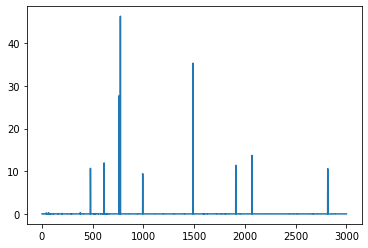

Succesful Episodes:
[477, 611, 758, 772, 992, 1486, 1909, 2069, 2815]
Testing :
Episode: 0 Reward:0.9600198572294781 function: 1.9481783776129846x^2 + 4.23555463324714y^2 + -5.917262018350442xy + 9.590717210536464x + 0.7628467934573067y + -7.67812850678141 x:-198.3367830232429 y:-96.15625315388323 x_min:42.718240603695605 y_min:29.74960750634257
Episode: 1 Reward:13.912069996461662 function: 3.421395139969717x^2 + 2.734211066368404y^2 + 7.8551693866772325xy + -2.8765018566980256x + -9.542559719311537y + -3.6878450262415345 x:-184.89389028642844 y:-37.74560590056644 x_min:2.438950400475628 y_min:-1.758424746429794
Episode: 2 Reward:130.67450170689654 function: 2.0884585371181617x^2 + 8.196498570360136y^2 + -3.1658927808217356xy + 8.346058239068899x + 7.372022242399993y + 4.218314083677953 x:-196.1977460173428 y:-95.24889637434453 x_min:-2.7400825406633205 y_min:-0.9788832169610575
Episode: 3 Reward:68.80518566821253 function: 4.701454235008016x^2 + 0.1999190160771369y^2 + 8.179304667637

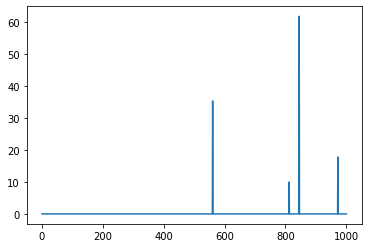

Succesful Episodes:
[560, 811, 844, 971]


In [8]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.autograd as autograd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gym

def main():

    # create env
    env = QuadraticEnv()
    env.seed(456)
    torch.manual_seed(456)
    np.random.seed(456)

    hidden_size = 32

    # get env info
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space

    print("number of actions:{0}, dim of states: {1}".format(action_dim,state_dim))

    # create policy
    policy = REINFORCE(state_dim, hidden_size, action_dim)

    

    # start of Training: Keep looping until desired amount of episodes reached
    max_episodes = 3000
    total_episodes = 0 # keep track of amount of episodes that we have done
    max_reward = 0
    max_reward_ep = 0
    reward_list = []
    succesful_episodes = []
    while total_episodes < max_episodes:

        obs = env.reset()
        done = False
        trajectory = [] # trajectory info for reinforce update
        episode_reward = 0 # keep track of rewards per episode

        while not done:
            action, ln_prob = policy.select_action(np.array(obs))
            next_state, reward, done = env.step(action)
            trajectory.append([obs, action, ln_prob, reward, next_state, done])
            obs = next_state
            episode_reward += reward
        reward_list.append(env.reward())
        print(f'Episode: {total_episodes} Reward:{episode_reward} function: {env.a}x^2 + {env.b}y^2 + {env.c}xy + {env.d}x + {env.e}y + {env.f} x:{env.state[0]} y:{env.state[1]} x_min:{env.x_min} y_min:{env.y_min}')
        if abs(env.state[0]-env.x_min) < 0.1 and (env.state[1]-env.y_min) < 0.1:
          succesful_episodes.append(total_episodes)
        if episode_reward > max_reward:
            max_reward = episode_reward
            max_reward_ep = total_episodes

        total_episodes += 1
        policy_loss = policy.train(trajectory)
    
    print(f'Max Reward is {max_reward} occured on episode {max_reward_ep}')
    eps = [ep for ep in range(1,max_episodes+1)]
    plt.plot(eps,reward_list)
    plt.show()
    print('Succesful Episodes:')
    print(succesful_episodes)
    print('Testing :')

    
    #start of testing
    max_episodes = 1000
    total_episodes = 0 # keep track of amount of episodes that we have done
    max_reward = 0
    max_reward_ep = 0
    reward_list = []
    succesful_episodes = []
    while total_episodes < max_episodes:

        obs = env.reset()
        done = False
        episode_reward = 0 # keep track of rewards per episode

        while not done:
            action, ln_prob = policy.select_action(np.array(obs))
            next_state, reward, done = env.step(action)
            trajectory.append([obs, action, ln_prob, reward, next_state, done])
            obs = next_state
            episode_reward += reward
        reward_list.append(env.reward())
        print(f'Episode: {total_episodes} Reward:{episode_reward} function: {env.a}x^2 + {env.b}y^2 + {env.c}xy + {env.d}x + {env.e}y + {env.f} x:{env.state[0]} y:{env.state[1]} x_min:{env.x_min} y_min:{env.y_min}')
        if abs(env.state[0]-env.x_min) < 0.1 and (env.state[1]-env.y_min) < 0.1:
          succesful_episodes.append(total_episodes)
        if episode_reward > max_reward:
            max_reward = episode_reward
            max_reward_ep = total_episodes

        total_episodes += 1
    
    print(f'Max Reward is {max_reward} occured on episode {max_reward_ep}')
    eps = [ep for ep in range(1,max_episodes+1)]
    plt.plot(eps,reward_list)
    plt.show()
    print('Succesful Episodes:')
    print(succesful_episodes)



if __name__ == '__main__':

    main()


The agent was trained for 3000 episodes where 9 episodes were successful. The testing of the agent was carried out on 1000 episodes where 4 episodes were successful.